Векторизация всех текстов с помощью 3 методов: word2vec, BagOfWords, tf-idf

Обьяснгить почему именно такой 'k', выбрать оптимальный с помощью перебора

In [56]:
# Delete numpy, then install 'gensim' and restart kernel 
!pip install gensim nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.7/782.7 KB 10.6 MB/s eta 0:00:00m eta 0:00:010:01
  Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)


In [29]:
!pip uninstall numpy

In [92]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer #  Tf–idf
from gensim.models import Word2Vec # Word2Vec
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
habr = pd.read_csv('habr_dataset.csv')

In [3]:
habr.columns

Index(['url', 'title', 'theme', 'tags', 'read_time', 'number_of_views', 'date',
       'amount_of_imgs', 'comments', 'bookmark', 'votes', 'text'],
      dtype='object')

In [4]:
X = habr['text']

# CountVectorizer

In [5]:
count_vectorizer = CountVectorizer()
count_vec = count_vectorizer.fit_transform(X)
count_vec.shape

(4338, 399348)

In [38]:
kmeans = KMeans(n_clusters=30, n_init = 1, init='k-means++', random_state=42)
kmeans.fit(count_vec)

KMeans(n_clusters=30, n_init=1, random_state=42)

In [39]:
kmeans.inertia_ # Сумма квадратов расстояний образцов до ближайшего центра кластера, взвешенная по весам выборок, если таковые имеются.

23948285.441837978

### При векторизации слов, с помощью CountVectorizer, слишком большая ошибка. Не имеет смысла подбирать количество кластеров

# TfidfVectorizer

In [6]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vec = tfidf_vectorizer.fit_transform(X)
tfidf_vec.shape

(4338, 399348)

In [51]:
kmeans_tfidf = KMeans(n_clusters=30, n_init = 1, init='k-means++', random_state=42)
kmeans_tfidf.fit(tfidf_vec)

KMeans(n_clusters=30, n_init=1, random_state=42)

In [52]:
kmeans_tfidf.inertia_

3890.3240544339747

# Word2Vec

In [67]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/den/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/den/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /home/den/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [93]:
# Очистка текста от стоп-слов и знаков пунктуации
stop_words = set(stopwords.words('russian'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [108]:
# Для классификации
#X_train, X_test, y_train, y_test = train_test_split(X, test_size=0.2, random_state=42)
#X_train = X_train.apply(preprocess)
#X_test = X_test.apply(preprocess)

X_cleared = X.apply(preprocess)
X_cleared.shape

(4338,)

In [109]:
# Обучение модели
sentences = [sentence.split() for sentence in X_cleared]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

Vector_size – размерность векторов слов.
window — максимальное расстояние между текущим и предсказанным словом в предложении.
min_count – игнорирует все слова с общей частотой ниже этой.
workers — используйте эти многочисленные рабочие потоки для обучения модели

In [111]:
# Векторизуем текстовые данные
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

#X_train = np.array([vectorize(sentence) for sentence in X_train])
#X_test = np.array([vectorize(sentence) for sentence in X_test])

X_vec = np.array([vectorize(sentence) for sentence in X_cleared])
X_vec

array([[-0.3203442 ,  0.18946964,  0.22275387, ..., -0.28023058,
         0.12504433,  0.27689427],
       [-0.34894016,  0.30149633,  0.03408966, ..., -0.35408986,
         0.10341793,  0.3491593 ],
       [-0.2971134 ,  0.24586643,  0.55369496, ..., -0.4089971 ,
         0.20448878,  0.08746017],
       ...,
       [-0.26468024,  0.29216927,  0.23910567, ..., -0.46705192,
         0.051978  ,  0.28298268],
       [-0.36931238,  0.2048547 ,  0.22599067, ..., -0.258942  ,
         0.14050904,  0.26674995],
       [-0.5167757 ,  0.4437564 ,  0.13445723, ..., -0.41944855,
         0.2737121 ,  0.49583247]], dtype=float32)

In [112]:
kmeans_w2v = KMeans(n_clusters=30, n_init = 1, init='k-means++', random_state=42)
kmeans_w2v.fit(X_vec)

KMeans(n_clusters=30, n_init=1, random_state=42)

In [113]:
kmeans_w2v.inertia_

3956.3330078125

# Plot

In [134]:
def draw_error(error_list, labels):
    ticks = np.arange(len(error_list))
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    ax.plot(error_list, marker='.', label = 'Ошибка')
    ax.set_title('Ошибка')
    ax.xaxis.set_major_locator(ticker.FixedLocator(ticks))
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid()

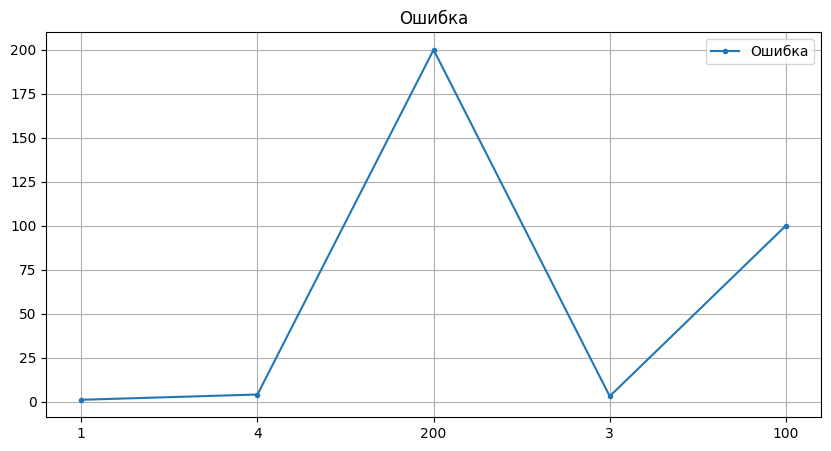

In [135]:
points = [1, 4, 200, 3, 100]
draw_error(points, points)

# Подбор k для KMeans с TfidfVectorizer

10
30
50
70
90
110
130


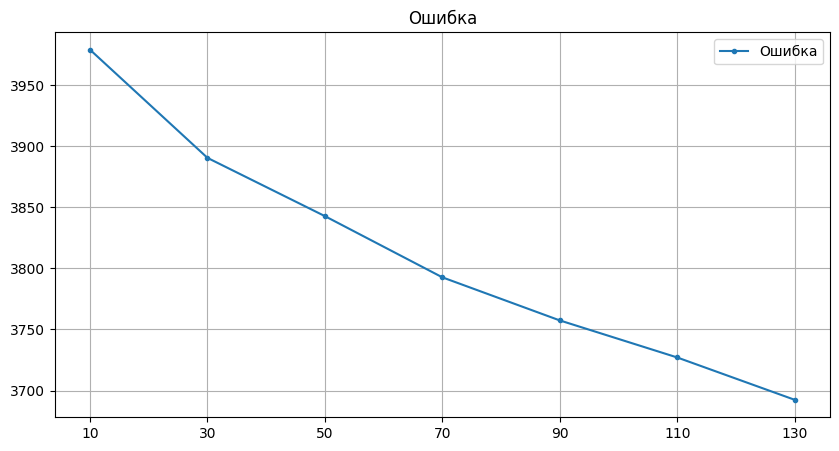

In [141]:
points = []
ticks = []
for i in range(10, 150, 20):
    kmeans_tfidf = KMeans(n_clusters=i, n_init = 1, init='k-means++', random_state=42)
    kmeans_tfidf.fit(tfidf_vec)
    points.append(kmeans_tfidf.inertia_)
    ticks.append(i)
    print(i)

draw_error(points, ticks)

# Подбор k для KMeans с Word2Vec

500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


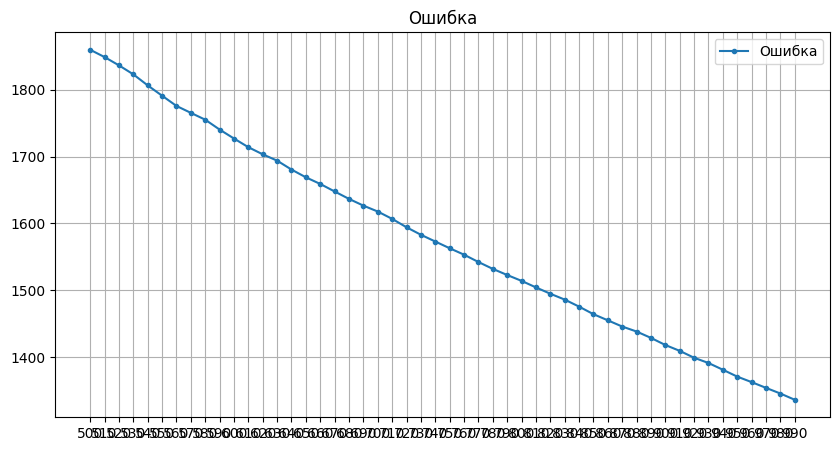

In [138]:
points = []
ticks = []

for i in range(500, 1000, 10):
    kmeans_w2v = KMeans(n_clusters=i, n_init = 1, init='k-means++', random_state=42)
    kmeans_w2v.fit(X_vec)
    points.append(kmeans_w2v.inertia_)
    ticks.append(i)
    print(i)

draw_error(points, ticks)

In [130]:
ticks

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]